# Week 6: Clustering and Association Mining

### What's on this week
1. [Preparing data for clustering](#prep)
2. [Building your first K-means clustering](#clustering)
3. [Understanding and visualising your clustering model](#viz)
4. [Implementing your own Apriori algorithm](#apriori)
5. [Running and understanding results of association mining](#assoc)
6. [Extending association mining to sequence mining](#sequence)

---

The practical note for this week introduces you to clustering and association rules mining using Python. In addition to the usual data preprocessing, model building and result evaluation/visualisation, I will also introduce you to implementing your own algorithm instead of only just using sklearn's.

**This tutorial notes is in experimental version. Please give us feedbacks and suggestions on how to make it better. Ask your tutor for any question and clarification.**

## 1. Preparing data for clustering<a name="prep"></a>

For our clustering this week, we will be using the `Census2000` dataset. This dataset contains the postal code-level summary of the 2000 United States Census. It has 7 variables:
* `ID`: Postal code of the region
* `LOCX`: Region longitude
* `LOCY`: Region latitude
* `MEANHHSZ`: Average household size in the region
* `MEDHHINC`: Median household income in the region
* `REGDENS`: Region population density percentile (1=lowest density, 100 = highest density)
* `REGPOP`: Number of people in the region

As usual, load up the data into pandas.

In [1]:
import pandas as pd
df = pd.read_csv('census2000.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 7 columns):
ID          33178 non-null object
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     32165 non-null float64
RegPop      33178 non-null int64
MedHHInc    33178 non-null int64
MeanHHSz    33178 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.8+ MB


Just like week 2, we need to visualise the data to see whether there is data problems within it. We can use `seaborn` and `matplotlib` for that purpose.

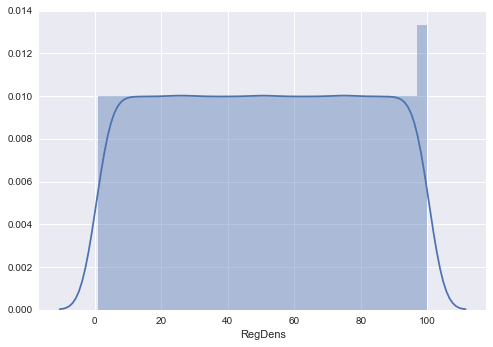

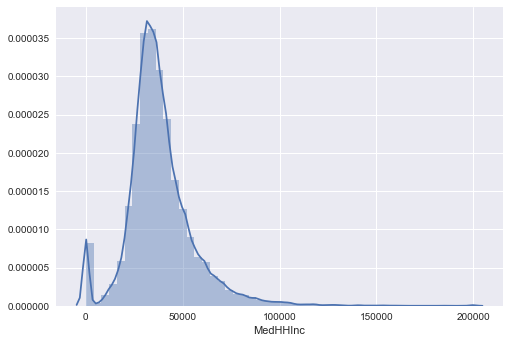

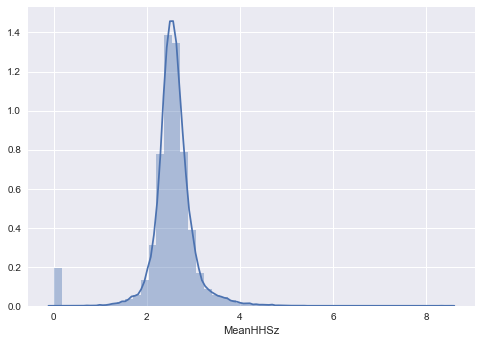

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of RegDens
regdens_dist = sns.distplot(df['RegDens'].dropna())
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df['MedHHInc'].dropna())
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna())

plt.show()

There seems to be some anomalies in `MeanHHSz` data. Let's zoom in closer.

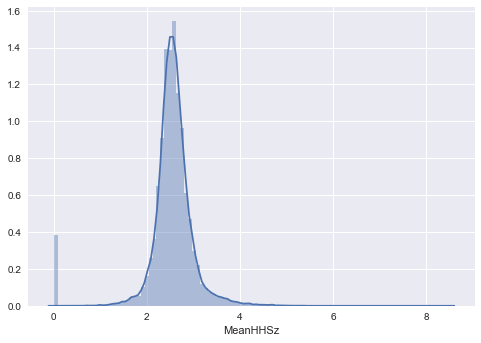

In [3]:
# Distribution of MeanHHSz, with increased number of bins. More bins = more specific distplot.
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna(), bins=100)
plt.show()

It becomes apparent that many of the records are valued at zero, and it seems very unlikely for an household to have zero members. This points out to a data problem. I wonder how does these errorneous values affect other variables. We could explore this relation using FaceTGrid.

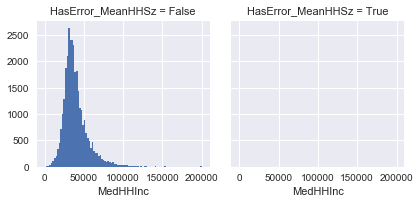

In [4]:
import numpy as np
df['HasError_MeanHHSz'] = df['MeanHHSz'] < 0.1

g = sns.FacetGrid(df, col='HasError_MeanHHSz')
g = g.map(plt.hist, 'MedHHInc', bins=100)

plt.show()

FacetGrid shows that errorneous data in `MeanHHSz` are correlated with errorneous data in other features. We can see that in `MedHHInc` here, most records with `MeanHHSz` also has way lower than normal values. This serves as a good reason to eliminate all rows with errorneous `MeanHHSz`.

In [5]:
# before
print("Before dropping errorneous rows", len(df))

# a very easy way to drop rows with MeanHHSz values below 0.1
df = df[df['MeanHHSz'] >= 0.1]

# after
print("After dropping errorneous rows", len(df))

Before dropping errorneous rows 33178
After dropping errorneous rows 32097


## 2. Building your first K-means clustering<a name="clustering"></a>

Now we are set to build our clustering model. Just before we jump in the models, let's determine the objective of this clustering process first. There are a number of good grouping objectives that we can apply in this dataset. We could cluster them based on location (`LocX` and `LocY`), demographic characteristics or both. For this tutorial, I would like to focus on demographic characteristics.

Thus, let's use `MedHHInc`, `MeanHHSz` and `RegDens` and drop the rest. You might wonder why `RegPop` is discarded too. Firstly, its a data about number of people in an area, which is already covered by `RegDens`. Secondly, `RegPop` is highly influenced by the actual size of the region, an information we do not have. In comparing regions using their demographic information, it is more accurate to use `RegDens`.

In [7]:
from sklearn.preprocessing import StandardScaler
df2 = df[['MedHHInc', 'MeanHHSz', 'RegDens']]
scaler = StandardScaler()

X = df2.as_matrix()
X = scaler.fit_transform(X)

Import our K-Means clustering from sklearn. Build a K-means cluster with K=3 and print out its `inertia` (sum of distances of samples to their closest cluster center/centroid). Remember, in clustering, we want to minimize the intra-cluster distance while maximizing the inter-cluster distances.

In [14]:
from sklearn.cluster import KMeans

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=42)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 52549.9072954
Centroid locations:
[-0.41275655 -0.08490495 -0.88299186]
[ 1.32604863  0.91415041  0.7568173 ]
[-0.17389581 -0.4089853   0.83829636]


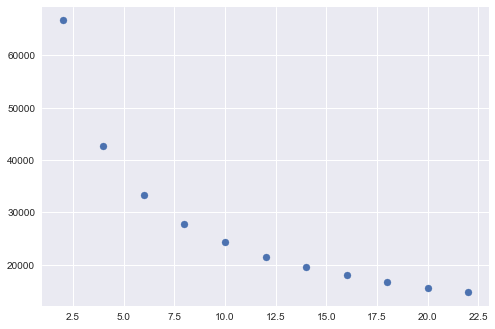

In [26]:
cluster_costs = []

for k in range(2, 23, 2):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    
    cluster_costs.append(model.inertia_)

plt.scatter(range(2,23, 2), cluster_costs)
plt.show()

## 3. Understanding and Visualising Your Clustering Model

Let's dive deeper into our clustering model.



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Cluster membership
0    15336
2    10597
1     6164
Name: Cluster_ID, dtype: int64


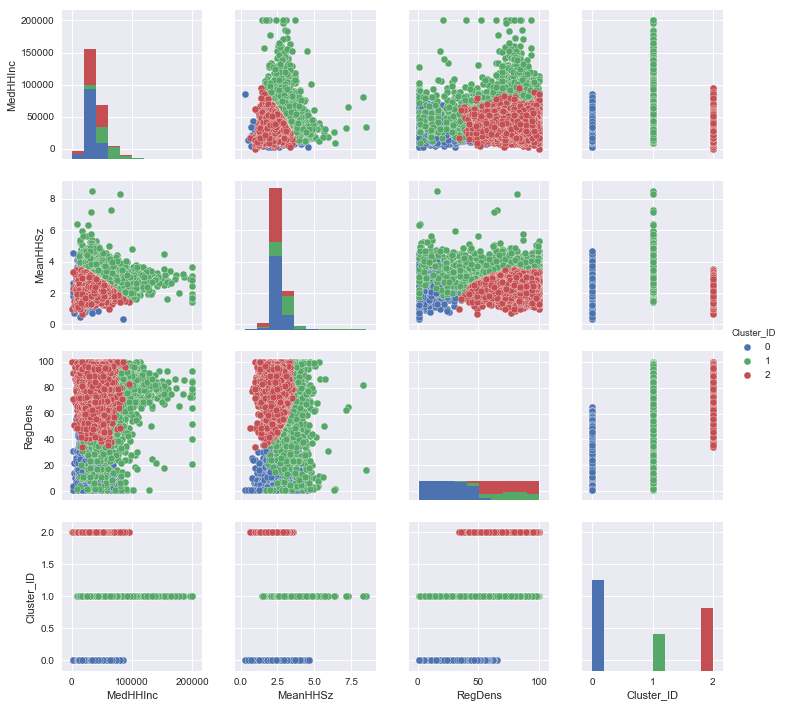

In [21]:
y = model.predict(X)
df2['Cluster_ID'] = y

print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

In [22]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=42)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27888.0052791
Centroid locations:
[-0.24637461  0.49506801 -0.94539867]
[-0.19894362 -1.04645703  1.14580103]
[-0.27198044 -0.15249401 -0.00368778]
[ 3.41626444  0.55361654  0.97391772]
[-0.43350059  0.69262846  1.1340166 ]
[ 1.1143193   0.3109762   0.77048989]
[-0.31455058  3.22918414  0.14403039]
[-0.5753844  -0.70480196 -1.19325666]


Explanation.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Cluster membership
2    7369
7    6072
0    5296
5    4897
1    3987
4    2468
3    1030
6     978
Name: Cluster_ID, dtype: int64


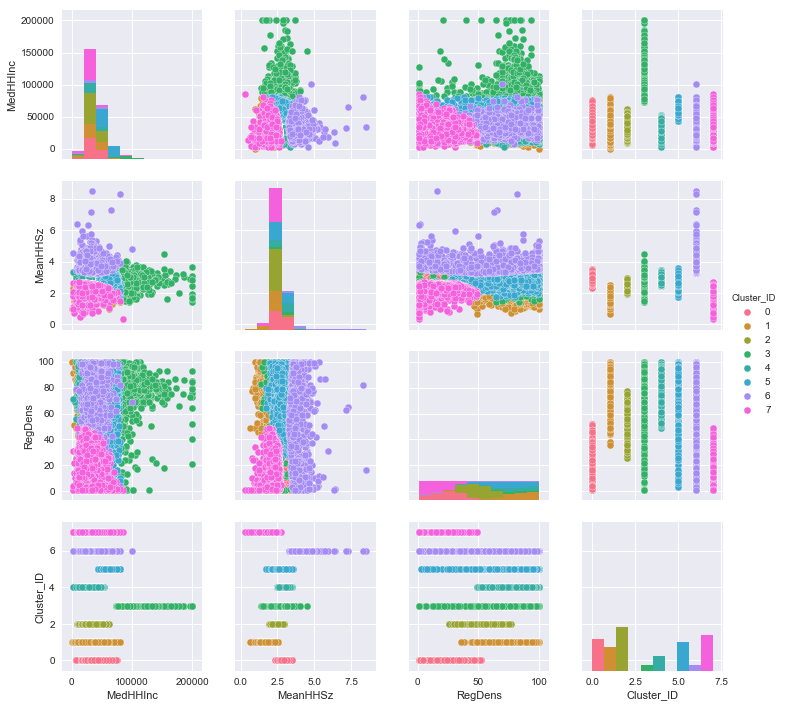

In [23]:
y = model.predict(X)
df2['Cluster_ID'] = y

print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

More explaination

Visualisation

Association

Implementing our own apriori algorithm

In [ ]:
Running it on our dataset